<a href="https://colab.research.google.com/github/shintaroudlotulhanafia/TugasAkhirMultipleStocks/blob/main/3Indikator/Running2_MultipleStockTrading_MACD_CCI_RSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
    * [4.3. Seeing Dataset Based on tic](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
    * [6.1. Download the Actions of the Agents](#5.1)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of LQ45 index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [1]:
# install finrl library
!pip install git+https://github.com/shintaroudlotulhanafia/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/shintaroudlotulhanafia/FinRL.git to /tmp/pip-req-build-gv4yg44v
  Running command git clone -q https://github.com/shintaroudlotulhanafia/FinRL.git /tmp/pip-req-build-gv4yg44v
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-fqupjbv_/pyfolio_ec241fe76f444fba8859a8a43e7e7451
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-fqupjbv_/pyfolio_ec241fe76f444fba8859a8a43e7e7451
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-fqupjbv_/elegantrl_4cf466189ec646f7ae1a108cc9de15b1
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-fqupjbv_/elegantrl_4cf466189ec646f7ae1a108cc9de15b1
     |████████████████████████████████| 2.3 MB 14.7 MB/s 
     |████████████████████████████████| 234 kB 76.1 MB/s 
     |█████████████████████


<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data
        end_date : str
            end date of the data
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [4]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2016-12-31'
TRADE_START_DATE = '2017-01-01'
TRADE_END_DATE = '2018-12-31'

In [5]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.JII_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
print(config_tickers.JII_TICKER)

['ADRO.JK', 'ANTM.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'EMTK.JK', 'ERAA.JK', 'EXCL.JK', 'HRUM.JK', 'ICBP.JK', 'INCO.JK', 'INDF.JK', 'INKP.JK', 'INTP.JK', 'ITMG.JK', 'JPFA.JK', 'KLBF.JK', 'MDKA.JK', 'MIKA.JK', 'MNCN.JK', 'PGAS.JK', 'PTBA.JK', 'SCMA.JK', 'SMGR.JK', 'TINS.JK', 'TLKM.JK', 'TPIA.JK', 'UNTR.JK', 'UNVR.JK', 'WIKA.JK']


In [7]:
df.shape

(67401, 8)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-05,520.000000,520.000000,485.000000,276.809021,3.0,ADRO.JK,0
1,2009-01-05,957.573608,1049.971069,949.173828,820.693359,158999024.0,ANTM.JK,0
2,2009-01-05,61.000000,70.000000,60.000000,64.386536,95470000.0,BRPT.JK,0
3,2009-01-05,89.000000,94.000000,88.000000,73.513832,41810000.0,CPIN.JK,0
4,2009-01-05,868.023865,868.023865,868.023865,766.323242,4055.0,EXCL.JK,0


In [9]:
print(df['tic'].unique())

['ADRO.JK' 'ANTM.JK' 'BRPT.JK' 'CPIN.JK' 'EXCL.JK' 'ICBP.JK' 'INCO.JK'
 'INDF.JK' 'INKP.JK' 'INTP.JK' 'ITMG.JK' 'JPFA.JK' 'KLBF.JK' 'MNCN.JK'
 'PGAS.JK' 'PTBA.JK' 'SCMA.JK' 'SMGR.JK' 'TINS.JK' 'TLKM.JK' 'TPIA.JK'
 'UNTR.JK' 'UNVR.JK' 'WIKA.JK' 'EMTK.JK' 'HRUM.JK' 'ERAA.JK' 'MIKA.JK'
 'MDKA.JK' 'BRIS.JK']


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD, RSI, and CCI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 1998, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [25]:
INDICATORS = [
    "macd",
    "rsi_30",
    "cci_30",
]

In [26]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2513, 8)
Successfully added vix
Successfully added turbulence index


In [27]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [28]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2009-01-05,ADRO.JK,520.000000,520.000000,485.000000,276.809021,3.0,0.0,0.0,0.0,66.666667,39.080002,0.0
1,2009-01-05,ANTM.JK,957.573608,1049.971069,949.173828,820.693359,158999024.0,0.0,0.0,0.0,66.666667,39.080002,0.0
2,2009-01-05,BRPT.JK,61.000000,70.000000,60.000000,64.386536,95470000.0,0.0,0.0,0.0,66.666667,39.080002,0.0
3,2009-01-05,CPIN.JK,89.000000,94.000000,88.000000,73.513832,41810000.0,0.0,0.0,0.0,66.666667,39.080002,0.0
4,2009-01-05,ICBP.JK,475.000000,490.000000,460.000000,375.615784,309281000.0,0.0,0.0,0.0,66.666667,39.080002,0.0
5,2009-01-05,INCO.JK,2050.000000,2300.000000,2030.000000,1792.011353,30353500.0,0.0,0.0,0.0,66.666667,39.080002,0.0
6,2009-01-05,INDF.JK,980.000000,980.000000,920.000000,638.532898,154640500.0,0.0,0.0,0.0,66.666667,39.080002,0.0
7,2009-01-05,INKP.JK,760.000000,810.000000,760.000000,703.680359,5843000.0,0.0,0.0,0.0,66.666667,39.080002,0.0
8,2009-01-05,INTP.JK,4600.000000,5050.000000,4600.000000,3106.131348,3534000.0,0.0,0.0,0.0,66.666667,39.080002,0.0
9,2009-01-05,ITMG.JK,10700.000000,12600.000000,10700.000000,3518.224609,2041000.0,0.0,0.0,0.0,66.666667,39.080002,0.0


In [29]:
processed_full.nunique()

date           2406
tic              22
open           5281
high           5391
low            5382
close         21183
volume        43635
day               5
macd          52892
rsi_30        46147
cci_30        52824
vix            1399
turbulence     2153
dtype: int64

In [30]:
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52932 entries, 0 to 80167
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        52932 non-null  object 
 1   tic         52932 non-null  object 
 2   open        52932 non-null  float64
 3   high        52932 non-null  float64
 4   low         52932 non-null  float64
 5   close       52932 non-null  float64
 6   volume      52932 non-null  float64
 7   day         52932 non-null  float64
 8   macd        52932 non-null  float64
 9   rsi_30      52932 non-null  float64
 10  cci_30      52932 non-null  float64
 11  vix         52932 non-null  float64
 12  turbulence  52932 non-null  float64
dtypes: float64(11), object(2)
memory usage: 5.7+ MB


In [31]:
print(processed_full['tic'].unique())

['ADRO.JK' 'ANTM.JK' 'BRPT.JK' 'CPIN.JK' 'ICBP.JK' 'INCO.JK' 'INDF.JK'
 'INKP.JK' 'INTP.JK' 'ITMG.JK' 'KLBF.JK' 'MNCN.JK' 'PGAS.JK' 'PTBA.JK'
 'SCMA.JK' 'SMGR.JK' 'TINS.JK' 'TLKM.JK' 'TPIA.JK' 'UNTR.JK' 'UNVR.JK'
 'WIKA.JK']


In [32]:
#Save the dataset by the tic filter

for stock in processed_full['tic'].unique():
  df_temp = processed_full.loc[processed_full['tic'].isin([stock])]
  df_temp.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading(2)/JIIDatasetPerTic/'+ stock +'.csv',index=False)
  display(df_temp)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2009-01-05,ADRO.JK,520.0,520.0,485.0,276.809021,3.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
22,2009-01-06,ADRO.JK,520.0,540.0,510.0,271.485809,11781500.0,1.0,-0.119431,0.000000,66.666667,38.560001,0.000000
44,2009-01-07,ADRO.JK,520.0,550.0,510.0,276.809021,27035500.0,2.0,0.012894,50.847458,74.277141,43.389999,0.000000
66,2009-01-08,ADRO.JK,500.0,510.0,500.0,266.162659,2130000.0,3.0,-0.311621,24.779338,-74.170900,42.560001,0.000000
88,2009-01-09,ADRO.JK,510.0,520.0,510.0,271.485809,1698000.0,4.0,-0.269577,40.545212,-6.721681,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79992,2018-12-20,ADRO.JK,1245.0,1275.0,1245.0,904.556702,76760400.0,3.0,-43.378819,35.875646,-62.710713,28.379999,18.141761
80014,2018-12-21,ADRO.JK,1255.0,1260.0,1235.0,900.952881,65802400.0,4.0,-41.667216,35.645754,-68.833323,30.110001,21.629630
80080,2018-12-24,ADRO.JK,1250.0,1250.0,1250.0,900.952881,0.0,0.0,-39.851376,35.645754,-66.793077,36.070000,0.054180
80124,2018-12-26,ADRO.JK,1240.0,1240.0,1215.0,879.330017,42011200.0,2.0,-37.796267,34.190466,-94.545370,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
1,2009-01-05,ANTM.JK,957.573608,1049.971069,949.173828,820.693359,158999024.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
23,2009-01-06,ANTM.JK,1041.571289,1041.571289,965.973389,787.331787,91663240.0,1.0,-0.748497,0.000000,-66.666667,38.560001,0.000000
45,2009-01-07,ANTM.JK,1033.171509,1108.769409,999.572449,820.693359,302919657.0,2.0,0.080807,50.847458,100.000000,43.389999,0.000000
67,2009-01-08,ANTM.JK,974.373169,1007.972229,965.973389,773.987244,54473525.0,3.0,-1.230296,29.283092,-94.222532,42.560001,0.000000
89,2009-01-09,ANTM.JK,991.172668,1049.971069,982.772888,834.037964,76111621.0,4.0,0.472727,54.786691,44.159991,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79993,2018-12-20,ANTM.JK,755.000000,780.000000,755.000000,732.253296,85694000.0,3.0,18.649285,53.886007,110.352894,28.379999,18.141761
80015,2018-12-21,ANTM.JK,765.000000,795.000000,760.000000,737.039368,135346100.0,4.0,19.668111,54.389376,113.247082,30.110001,21.629630
80081,2018-12-24,ANTM.JK,770.000000,770.000000,770.000000,737.039368,0.0,0.0,20.242199,54.389376,97.805663,36.070000,0.054180
80125,2018-12-26,ANTM.JK,760.000000,790.000000,760.000000,737.039368,71071800.0,2.0,20.399787,54.389376,89.371159,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
2,2009-01-05,BRPT.JK,61.0,70.0,60.0,64.386536,95470000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
24,2009-01-06,BRPT.JK,66.0,71.0,62.0,60.484322,72175000.0,1.0,-0.087550,0.000000,-66.666667,38.560001,0.000000
46,2009-01-07,BRPT.JK,63.0,70.0,61.0,61.459877,80160000.0,2.0,-0.081304,20.547977,-100.000000,43.389999,0.000000
68,2009-01-08,BRPT.JK,64.0,65.0,61.0,62.435429,29180000.0,3.0,-0.041249,34.476041,-133.333333,42.560001,0.000000
90,2009-01-09,BRPT.JK,62.0,66.0,62.0,60.484322,42590000.0,4.0,-0.096254,25.299921,-82.652044,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79994,2018-12-20,BRPT.JK,448.0,472.0,444.0,456.819336,88274000.0,3.0,15.420291,66.918831,187.486401,28.379999,18.141761
80016,2018-12-21,BRPT.JK,460.0,470.0,458.0,464.764038,17839000.0,4.0,17.296320,68.221182,201.518269,30.110001,21.629630
80082,2018-12-24,BRPT.JK,468.0,468.0,468.0,464.764038,0.0,0.0,18.569033,68.221182,199.793054,36.070000,0.054180
80126,2018-12-26,BRPT.JK,468.0,470.0,462.0,458.805481,17528500.0,2.0,19.274112,66.061793,152.381639,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
3,2009-01-05,CPIN.JK,89.0,94.0,88.0,73.513832,41810000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
25,2009-01-06,CPIN.JK,94.0,98.0,94.0,75.077957,33797500.0,1.0,0.035093,100.000000,66.666667,38.560001,0.000000
47,2009-01-07,CPIN.JK,96.0,98.0,94.0,75.077957,20977500.0,2.0,0.044715,100.000000,50.000000,43.389999,0.000000
69,2009-01-08,CPIN.JK,95.0,96.0,94.0,74.295891,26135000.0,3.0,0.019759,65.143189,13.445711,42.560001,0.000000
91,2009-01-09,CPIN.JK,95.0,95.0,94.0,74.295891,3950000.0,4.0,0.005783,65.143189,-3.220444,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,2018-12-20,CPIN.JK,7150.0,7175.0,6750.0,6330.066895,9315800.0,3.0,323.860409,61.068361,96.068392,28.379999,18.141761
80017,2018-12-21,CPIN.JK,6825.0,6825.0,6575.0,6167.757812,12533700.0,4.0,296.656361,58.749300,63.849594,30.110001,21.629630
80083,2018-12-24,CPIN.JK,6650.0,6650.0,6650.0,6167.757812,0.0,0.0,271.961949,58.749300,55.724570,36.070000,0.054180
80127,2018-12-26,CPIN.JK,6650.0,6950.0,6475.0,6376.440918,3081500.0,2.0,245.732312,60.864637,61.460723,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
4,2009-01-05,ICBP.JK,475.0,490.0,460.0,375.615784,309281000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
26,2009-01-06,ICBP.JK,500.0,555.0,490.0,390.946991,692035000.0,1.0,0.343969,100.000000,66.666667,38.560001,0.000000
48,2009-01-07,ICBP.JK,520.0,540.0,510.0,390.946991,294285000.0,2.0,0.438285,100.000000,53.323549,43.389999,0.000000
70,2009-01-08,ICBP.JK,500.0,525.0,495.0,394.779846,47693000.0,3.0,0.608825,100.000000,17.715483,42.560001,0.000000
92,2009-01-09,ICBP.JK,515.0,555.0,510.0,417.776642,288827000.0,4.0,1.603771,100.000000,104.993212,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79996,2018-12-20,ICBP.JK,10200.0,10500.0,10150.0,9602.531250,24269900.0,3.0,309.540562,71.480820,129.442886,28.379999,18.141761
80018,2018-12-21,ICBP.JK,10250.0,10525.0,10250.0,9648.367188,7629400.0,4.0,328.870227,71.965514,128.206283,30.110001,21.629630
80084,2018-12-24,ICBP.JK,10525.0,10525.0,10525.0,9648.367188,0.0,0.0,340.266743,71.965514,133.288317,36.070000,0.054180
80128,2018-12-26,ICBP.JK,10550.0,10550.0,10125.0,9396.272461,3278500.0,2.0,325.230086,65.216848,95.956635,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
5,2009-01-05,INCO.JK,2050.0,2300.0,2030.0,1792.011353,30353500.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
27,2009-01-06,INCO.JK,2300.0,2325.0,2100.0,1733.576294,21013000.0,1.0,-1.311043,0.000000,66.666667,38.560001,0.000000
49,2009-01-07,INCO.JK,2300.0,2650.0,2275.0,2025.751343,58399500.0,2.0,7.389802,83.798871,100.000000,43.389999,0.000000
71,2009-01-08,INCO.JK,2525.0,2575.0,2400.0,1967.316650,26228000.0,3.0,9.056249,71.416894,65.969216,42.560001,0.000000
93,2009-01-09,INCO.JK,2525.0,2825.0,2525.0,2181.578857,21530000.0,4.0,18.297101,81.682977,109.658470,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79997,2018-12-20,INCO.JK,3170.0,3250.0,3130.0,3140.599854,12765100.0,3.0,2.195643,49.364982,57.243561,28.379999,18.141761
80019,2018-12-21,INCO.JK,3140.0,3190.0,3130.0,3120.785400,6029800.0,4.0,6.012534,48.922356,46.225421,30.110001,21.629630
80085,2018-12-24,INCO.JK,3150.0,3150.0,3150.0,3120.785400,0.0,0.0,8.934458,48.922356,45.796120,36.070000,0.054180
80129,2018-12-26,INCO.JK,3110.0,3160.0,3090.0,3081.156250,2553600.0,2.0,9.547657,47.970020,30.106668,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
6,2009-01-05,INDF.JK,980.0,980.0,920.0,638.532898,154640500.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
28,2009-01-06,INDF.JK,1000.0,1110.0,980.0,664.595581,346017500.0,1.0,0.584740,100.000000,66.666667,38.560001,0.000000
50,2009-01-07,INDF.JK,1020.0,1080.0,1020.0,664.595581,147142500.0,2.0,0.745074,100.000000,53.392703,43.389999,0.000000
72,2009-01-08,INDF.JK,1030.0,1050.0,990.0,671.111206,23846500.0,3.0,1.034982,100.000000,16.400218,42.560001,0.000000
94,2009-01-09,INDF.JK,1030.0,1110.0,1020.0,710.204895,144413500.0,4.0,2.726352,100.000000,101.730221,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79998,2018-12-20,INDF.JK,7275.0,7375.0,7150.0,6314.961426,16585400.0,3.0,265.538464,66.465704,148.807858,28.379999,18.141761
80020,2018-12-21,INDF.JK,7275.0,7550.0,7250.0,6443.838379,20143900.0,4.0,285.627584,67.997418,158.286171,30.110001,21.629630
80086,2018-12-24,INDF.JK,7500.0,7500.0,7500.0,6443.838379,0.0,0.0,298.111907,67.997418,159.176201,36.070000,0.054180
80130,2018-12-26,INDF.JK,7400.0,7400.0,7275.0,6336.441406,6946900.0,2.0,297.460083,65.247992,117.261373,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
7,2009-01-05,INKP.JK,760.0,810.0,760.0,703.680359,5843000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
29,2009-01-06,INKP.JK,800.0,870.0,800.0,730.068237,32535000.0,1.0,0.592036,100.000000,66.666667,38.560001,0.000000
51,2009-01-07,INKP.JK,840.0,980.0,830.0,818.028198,54487000.0,2.0,3.482004,100.000000,100.000000,43.389999,0.000000
73,2009-01-08,INKP.JK,900.0,950.0,900.0,791.640198,15397500.0,3.0,3.758355,80.607606,69.712267,42.560001,0.000000
95,2009-01-09,INKP.JK,920.0,960.0,910.0,809.232300,10715000.0,4.0,4.529427,82.895223,68.699644,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79999,2018-12-20,INKP.JK,11775.0,11925.0,11600.0,11328.519531,3573400.0,3.0,-89.813030,45.754026,16.124846,28.379999,18.141761
80021,2018-12-21,INKP.JK,11500.0,11800.0,11500.0,11255.747070,4147000.0,4.0,-91.037877,45.489934,-2.515101,30.110001,21.629630
80087,2018-12-24,INKP.JK,11600.0,11600.0,11600.0,11255.747070,0.0,0.0,-90.960046,45.489934,-11.229324,36.070000,0.054180
80131,2018-12-26,INKP.JK,11500.0,11700.0,11250.0,11304.260742,1874400.0,2.0,-84.108464,45.721152,-27.317147,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
8,2009-01-05,INTP.JK,4600.0,5050.0,4600.0,3106.131348,3534000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
30,2009-01-06,INTP.JK,5100.0,5250.0,5050.0,3198.392334,2973000.0,1.0,2.069958,100.000000,66.666667,38.560001,0.000000
52,2009-01-07,INTP.JK,5000.0,5250.0,4900.0,3075.377686,3731500.0,2.0,-1.177140,42.028986,16.197318,43.389999,0.000000
74,2009-01-08,INTP.JK,4500.0,5100.0,4500.0,3136.885254,530000.0,3.0,-0.404427,55.401809,-68.751687,42.560001,0.000000
96,2009-01-09,INTP.JK,4800.0,5000.0,4800.0,2952.362549,549500.0,4.0,-7.318616,32.287183,-54.671895,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80000,2018-12-20,INTP.JK,19450.0,19600.0,19375.0,16176.840820,875800.0,3.0,151.742112,54.001031,-11.421137,28.379999,18.141761
80022,2018-12-21,INTP.JK,19175.0,19400.0,18775.0,15657.021484,3007000.0,4.0,88.942819,51.093218,-76.170828,30.110001,21.629630
80088,2018-12-24,INTP.JK,18825.0,18825.0,18825.0,15657.021484,0.0,0.0,38.727500,51.093218,-122.558096,36.070000,0.054180
80132,2018-12-26,INTP.JK,18800.0,18800.0,17925.0,15012.442383,1155500.0,2.0,-83.633366,47.576402,-227.695048,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
9,2009-01-05,ITMG.JK,10700.0,12600.0,10700.0,3518.224609,2041000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
31,2009-01-06,ITMG.JK,12600.0,12800.0,12000.0,3476.173340,1479500.0,1.0,-0.943458,0.000000,66.666667,38.560001,0.000000
53,2009-01-07,ITMG.JK,12000.0,12800.0,11900.0,3364.039307,1520500.0,2.0,-4.679422,0.000000,38.231180,43.389999,0.000000
75,2009-01-08,ITMG.JK,11800.0,11800.0,11400.0,3307.971680,230000.0,3.0,-8.288232,0.000000,-80.391561,42.560001,0.000000
97,2009-01-09,ITMG.JK,12100.0,12200.0,11800.0,3392.072510,504500.0,4.0,-6.728151,29.921953,-2.156241,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80001,2018-12-20,ITMG.JK,20025.0,20150.0,19900.0,13037.813477,892300.0,3.0,-386.578418,41.623172,-76.914970,28.379999,18.141761
80023,2018-12-21,ITMG.JK,19900.0,20100.0,19750.0,12972.624023,1405200.0,4.0,-384.989755,41.304497,-80.740044,30.110001,21.629630
80089,2018-12-24,ITMG.JK,19900.0,19900.0,19900.0,12972.624023,0.0,0.0,-379.357728,41.304497,-79.964332,36.070000,0.054180
80133,2018-12-26,ITMG.JK,19800.0,20050.0,19675.0,12972.624023,411200.0,2.0,-359.554168,41.304497,-78.602052,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
10,2009-01-05,KLBF.JK,81.0,84.0,80.0,63.608841,165165000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
32,2009-01-06,KLBF.JK,81.0,82.0,80.0,63.608841,44137500.0,1.0,0.000000,0.000000,-66.666667,38.560001,0.000000
54,2009-01-07,KLBF.JK,81.0,83.0,80.0,63.608841,166020000.0,2.0,0.000000,0.000000,0.000000,43.389999,0.000000
76,2009-01-08,KLBF.JK,81.0,81.0,80.0,63.608841,59210000.0,3.0,0.000000,0.000000,-100.000000,42.560001,0.000000
98,2009-01-09,KLBF.JK,81.0,96.0,81.0,74.602951,397677500.0,4.0,0.437481,100.000000,166.666667,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80002,2018-12-20,KLBF.JK,1490.0,1530.0,1460.0,1415.718140,31011500.0,3.0,5.484074,54.804550,-28.331225,28.379999,18.141761
80024,2018-12-21,KLBF.JK,1530.0,1550.0,1515.0,1429.597900,31783000.0,4.0,7.275106,55.645752,6.972306,30.110001,21.629630
80090,2018-12-24,KLBF.JK,1545.0,1545.0,1545.0,1429.597900,0.0,0.0,8.595429,55.645752,12.344705,36.070000,0.054180
80134,2018-12-26,KLBF.JK,1545.0,1545.0,1465.0,1397.212280,26290000.0,2.0,7.573538,53.093144,-69.542834,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
11,2009-01-05,MNCN.JK,156.0,160.0,148.0,125.801056,29500.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
33,2009-01-06,MNCN.JK,150.0,150.0,150.0,120.962563,16500.0,1.0,-0.108556,0.000000,-66.666667,38.560001,0.000000
55,2009-01-07,MNCN.JK,150.0,151.0,145.0,120.962563,381000.0,2.0,-0.138322,0.000000,-70.217686,43.389999,0.000000
77,2009-01-08,MNCN.JK,147.0,147.0,140.0,118.543335,105000.0,3.0,-0.235815,0.000000,-113.866643,42.560001,0.000000
99,2009-01-09,MNCN.JK,148.0,152.0,147.0,119.349747,218500.0,4.0,-0.251738,10.729851,-7.811717,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80003,2018-12-20,MNCN.JK,720.0,720.0,695.0,688.960754,43425800.0,3.0,-17.699258,36.867216,-206.883316,28.379999,18.141761
80025,2018-12-21,MNCN.JK,715.0,755.0,695.0,728.050720,68762100.0,4.0,-16.401382,43.440483,-117.232921,30.110001,21.629630
80091,2018-12-24,MNCN.JK,745.0,745.0,745.0,728.050720,0.0,0.0,-15.197618,43.440483,-71.272942,36.070000,0.054180
80135,2018-12-26,MNCN.JK,730.0,745.0,710.0,698.733215,23380600.0,2.0,-15.384949,39.983929,-117.128984,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
12,2009-01-05,PGAS.JK,1960.0,1980.0,1900.0,1129.860107,4.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
34,2009-01-06,PGAS.JK,1960.0,2060.0,1960.0,1170.212280,110572000.0,1.0,0.905337,100.000000,66.666667,38.560001,0.000000
56,2009-01-07,PGAS.JK,1950.0,2125.0,1925.0,1124.095581,4.0,2.0,-0.276497,45.823965,42.984354,43.389999,0.000000
78,2009-01-08,PGAS.JK,1900.0,2020.0,1880.0,1158.683350,56091500.0,3.0,0.441536,61.856842,-44.656697,42.560001,0.000000
100,2009-01-09,PGAS.JK,2125.0,2125.0,2025.0,1224.975952,4.0,4.0,3.460345,75.961803,139.710014,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80004,2018-12-20,PGAS.JK,2090.0,2120.0,2070.0,1715.797974,29389800.0,3.0,7.055726,50.853124,51.358269,28.379999,18.141761
80026,2018-12-21,PGAS.JK,2090.0,2180.0,2070.0,1773.264771,118177600.0,4.0,11.864422,53.627185,96.991261,30.110001,21.629630
80092,2018-12-24,PGAS.JK,2160.0,2160.0,2160.0,1773.264771,0.0,0.0,15.496711,53.627185,119.111661,36.070000,0.054180
80136,2018-12-26,PGAS.JK,2120.0,2150.0,2090.0,1715.797974,45034800.0,2.0,15.465918,50.473261,57.556388,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
13,2009-01-05,PTBA.JK,1430.0,1590.0,1420.0,667.636414,67257500.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
35,2009-01-06,PTBA.JK,1570.0,1590.0,1510.0,663.356689,50225000.0,1.0,-0.096019,0.000000,66.666667,38.560001,0.000000
57,2009-01-07,PTBA.JK,1510.0,1630.0,1500.0,646.237854,20.0,2.0,-0.653202,0.000000,60.482621,43.389999,0.000000
79,2009-01-08,PTBA.JK,1450.0,1490.0,1440.0,620.559509,20.0,3.0,-1.817718,0.000000,-121.077914,42.560001,0.000000
101,2009-01-09,PTBA.JK,1450.0,1590.0,1450.0,680.475586,38810000.0,4.0,-0.028032,57.280631,22.761761,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80005,2018-12-20,PTBA.JK,4220.0,4290.0,4220.0,2781.220703,10561700.0,3.0,-1.291175,49.928614,-10.513439,28.379999,18.141761
80027,2018-12-21,PTBA.JK,4220.0,4290.0,4220.0,2755.167236,14891400.0,4.0,-2.402543,49.243309,-12.158077,30.110001,21.629630
80093,2018-12-24,PTBA.JK,4230.0,4230.0,4230.0,2755.167236,0.0,0.0,-3.245893,49.243309,-16.021676,36.070000,0.054180
80137,2018-12-26,PTBA.JK,4210.0,4300.0,4210.0,2794.247559,9515600.0,2.0,-1.196727,50.374413,4.095678,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
14,2009-01-05,SCMA.JK,16.6,16.6,16.6,8.936810,50.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
36,2009-01-06,SCMA.JK,16.4,16.4,16.4,8.829136,87500.0,1.0,-0.002416,0.000000,-66.666667,38.560001,0.000000
58,2009-01-07,SCMA.JK,16.4,16.4,16.4,8.829136,50.0,2.0,-0.003078,0.000000,-50.000000,43.389999,0.000000
80,2009-01-08,SCMA.JK,16.4,16.4,16.4,8.829136,12500.0,3.0,-0.003304,0.000000,-44.444444,42.560001,0.000000
102,2009-01-09,SCMA.JK,16.4,16.4,16.4,8.829136,50.0,4.0,-0.003357,0.000000,-41.666667,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80006,2018-12-20,SCMA.JK,379.0,388.0,374.0,359.550476,81429000.0,3.0,6.165030,53.018367,52.837312,28.379999,18.141761
80028,2018-12-21,SCMA.JK,379.0,379.0,375.0,358.601807,38517500.0,4.0,5.588423,52.726917,24.594215,30.110001,21.629630
80094,2018-12-24,SCMA.JK,378.0,378.0,378.0,358.601807,0.0,0.0,5.072980,52.726917,24.225758,36.070000,0.054180
80138,2018-12-26,SCMA.JK,376.0,376.0,361.0,342.474213,23699000.0,2.0,2.910557,47.783374,-133.109115,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
15,2009-01-05,SMGR.JK,4200.0,4275.0,4200.0,2927.852051,3030000.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
37,2009-01-06,SMGR.JK,4200.0,4250.0,4200.0,2945.278564,1553000.0,1.0,0.390979,100.000000,-66.666667,38.560001,0.000000
59,2009-01-07,SMGR.JK,4250.0,4275.0,4175.0,2962.706787,2136500.0,2.0,1.038634,100.000000,100.000000,43.389999,0.000000
81,2009-01-08,SMGR.JK,4250.0,4250.0,4150.0,2962.706787,3490500.0,3.0,1.307745,100.000000,-133.333333,42.560001,0.000000
103,2009-01-09,SMGR.JK,4250.0,4250.0,4175.0,2962.706787,2615500.0,4.0,1.426445,100.000000,-22.214885,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80007,2018-12-20,SMGR.JK,11400.0,11550.0,11400.0,10731.670898,4191200.0,3.0,250.313018,59.100085,30.407474,28.379999,18.141761
80029,2018-12-21,SMGR.JK,11325.0,11500.0,11275.0,10755.052734,5685900.0,4.0,230.510016,59.292894,19.812301,30.110001,21.629630
80095,2018-12-24,SMGR.JK,11500.0,11500.0,11500.0,10755.052734,0.0,0.0,212.367949,59.292894,25.187795,36.070000,0.054180
80139,2018-12-26,SMGR.JK,11275.0,11575.0,11250.0,10801.813477,3075600.0,2.0,184.201196,59.713366,-6.679919,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
16,2009-01-05,TINS.JK,777.143066,858.236267,756.869751,604.524719,127721205.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
38,2009-01-06,TINS.JK,851.478516,864.994019,797.416382,585.333435,80194403.0,1.0,-0.430574,0.000000,66.666667,38.560001,0.000000
60,2009-01-07,TINS.JK,824.447449,898.782837,810.931885,585.333435,212559155.0,2.0,-0.548636,0.000000,100.000000,43.389999,0.000000
82,2009-01-08,TINS.JK,797.416382,824.447449,790.658630,566.142090,43543236.0,3.0,-1.281784,0.000000,-102.728709,42.560001,0.000000
104,2009-01-09,TINS.JK,810.931885,858.236267,797.416382,609.322632,54798436.0,4.0,0.065072,54.612188,46.916459,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80008,2018-12-20,TINS.JK,760.000000,775.000000,745.000000,712.743286,7297800.0,3.0,22.213970,57.279045,112.085962,28.379999,18.141761
80030,2018-12-21,TINS.JK,750.000000,770.000000,750.000000,712.743286,13662000.0,4.0,21.760728,57.279045,102.755620,30.110001,21.629630
80096,2018-12-24,TINS.JK,750.000000,750.000000,750.000000,712.743286,0.0,0.0,21.157639,57.279045,85.258004,36.070000,0.054180
80140,2018-12-26,TINS.JK,750.000000,750.000000,730.000000,693.736755,6845000.0,2.0,18.135746,53.230146,55.227814,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
17,2009-01-05,TLKM.JK,1460.0,1480.0,1420.0,995.788574,77242500.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
39,2009-01-06,TLKM.JK,1440.0,1490.0,1430.0,982.147522,103442500.0,1.0,-0.306049,0.000000,66.666667,38.560001,0.000000
61,2009-01-07,TLKM.JK,1380.0,1460.0,1380.0,941.224731,66135000.0,2.0,-1.658981,0.000000,-100.000000,43.389999,0.000000
83,2009-01-08,TLKM.JK,1400.0,1420.0,1360.0,954.865845,45320000.0,3.0,-1.741156,20.685084,-88.597776,42.560001,0.000000
105,2009-01-09,TLKM.JK,1420.0,1430.0,1390.0,968.506653,92242500.0,4.0,-1.206354,34.665323,-33.987008,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80009,2018-12-20,TLKM.JK,3810.0,3810.0,3720.0,3224.021973,100129200.0,3.0,-18.193011,49.806148,-36.804332,28.379999,18.141761
80031,2018-12-21,TLKM.JK,3700.0,3770.0,3700.0,3241.262695,114752300.0,4.0,-15.512093,50.422984,-44.298766,30.110001,21.629630
80097,2018-12-24,TLKM.JK,3760.0,3760.0,3760.0,3241.262695,0.0,0.0,-13.234882,50.422984,-29.707399,36.070000,0.054180
80141,2018-12-26,TLKM.JK,3730.0,3750.0,3700.0,3215.401611,50416400.0,2.0,-11.718138,49.414579,-50.320718,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
18,2009-01-05,TPIA.JK,331.79541,331.79541,331.79541,274.670654,0.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
40,2009-01-06,TPIA.JK,331.79541,331.79541,331.79541,274.670654,0.0,1.0,0.000000,0.000000,66.666667,38.560001,0.000000
62,2009-01-07,TPIA.JK,331.79541,331.79541,331.79541,274.670654,15.0,2.0,0.000000,0.000000,-100.000000,43.389999,0.000000
84,2009-01-08,TPIA.JK,331.79541,331.79541,331.79541,274.670654,0.0,3.0,0.000000,20.685084,-88.597776,42.560001,0.000000
106,2009-01-09,TPIA.JK,331.79541,331.79541,331.79541,274.670654,0.0,4.0,0.000000,34.665323,-33.987008,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80010,2018-12-20,TPIA.JK,5700.00000,5700.00000,5500.00000,5474.055664,1676600.0,3.0,151.346466,60.386960,131.762501,28.379999,18.141761
80032,2018-12-21,TPIA.JK,5525.00000,5700.00000,5525.00000,5622.002930,1382900.0,4.0,160.671763,63.033181,145.903133,30.110001,21.629630
80098,2018-12-24,TPIA.JK,5700.00000,5700.00000,5700.00000,5622.002930,0.0,0.0,166.146891,63.033181,157.112306,36.070000,0.054180
80142,2018-12-26,TPIA.JK,5700.00000,5800.00000,5625.00000,5695.975586,1511100.0,2.0,174.400722,64.351333,146.166992,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
19,2009-01-05,UNTR.JK,4326.423828,5071.530273,4326.423828,3122.124512,25673281.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
41,2009-01-06,UNTR.JK,5143.637207,5335.922852,4759.066406,3048.140625,23181674.0,1.0,-1.659895,0.000000,66.666667,38.560001,0.000000
63,2009-01-07,UNTR.JK,5239.779785,5576.279785,4951.351562,3225.701904,22293412.0,2.0,3.391129,71.287123,99.307878,43.389999,0.000000
85,2009-01-08,UNTR.JK,4999.423340,5239.779785,4855.208984,3077.735596,6885594.0,3.0,0.263059,44.153258,5.365188,42.560001,0.000000
107,2009-01-09,UNTR.JK,5191.708496,5239.779785,4951.351562,3196.108643,7648522.0,4.0,3.268110,57.531071,42.654721,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80011,2018-12-20,UNTR.JK,28650.000000,28925.000000,28600.000000,24326.099609,2936200.0,3.0,-719.694760,42.657987,-68.307627,28.379999,18.141761
80033,2018-12-21,UNTR.JK,28500.000000,28775.000000,27950.000000,23587.666016,9103000.0,4.0,-753.277838,40.497546,-82.109548,30.110001,21.629630
80099,2018-12-24,UNTR.JK,27950.000000,27950.000000,27950.000000,23587.666016,0.0,0.0,-771.005004,40.497546,-88.418523,36.070000,0.054180
80143,2018-12-26,UNTR.JK,27850.000000,27875.000000,27000.000000,22912.525391,5822200.0,2.0,-825.117894,38.522795,-107.985152,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
20,2009-01-05,UNVR.JK,1620.0,1620.0,1560.0,1149.686279,20.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
42,2009-01-06,UNVR.JK,1620.0,1670.0,1600.0,1163.880371,16432500.0,1.0,0.318457,100.000000,66.666667,38.560001,0.000000
64,2009-01-07,UNVR.JK,1560.0,1660.0,1550.0,1107.105469,20.0,2.0,-1.354809,19.463492,-58.540210,43.389999,0.000000
86,2009-01-08,UNVR.JK,1590.0,1610.0,1570.0,1128.395874,20.0,3.0,-1.313958,38.635271,-59.838526,42.560001,0.000000
108,2009-01-09,UNVR.JK,1600.0,1630.0,1580.0,1135.493042,20.0,4.0,-0.981685,43.290587,-2.719702,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80012,2018-12-20,UNVR.JK,8900.0,9050.0,8785.0,8173.575195,8704500.0,3.0,117.958328,55.939016,110.168088,28.379999,18.141761
80034,2018-12-21,UNVR.JK,9000.0,9320.0,8960.0,8417.426758,17106000.0,4.0,145.436661,59.242637,151.030505,30.110001,21.629630
80100,2018-12-24,UNVR.JK,9320.0,9320.0,9320.0,8417.426758,0.0,0.0,165.307872,59.242637,166.518921,36.070000,0.054180
80144,2018-12-26,UNVR.JK,9200.0,9320.0,9005.0,8223.248047,7617000.0,2.0,172.184473,55.569649,113.547483,30.410000,16.390973


,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
21,2009-01-05,WIKA.JK,208.366516,212.996887,203.736145,164.501938,41814179.0,0.0,0.000000,0.000000,66.666667,39.080002,0.000000
43,2009-01-06,WIKA.JK,208.366516,212.996887,199.105789,164.501938,28309850.0,1.0,0.000000,100.000000,-66.666667,38.560001,0.000000
65,2009-01-07,WIKA.JK,208.366516,217.627258,203.736145,164.501938,53218783.0,2.0,0.000000,19.463492,100.000000,43.389999,0.000000
87,2009-01-08,WIKA.JK,208.366516,208.366516,194.475418,164.501938,10329094.0,3.0,0.000000,38.635271,-120.000070,42.560001,0.000000
109,2009-01-09,WIKA.JK,208.366516,217.627258,208.366516,164.501938,30700049.0,4.0,0.000000,43.290587,101.851903,42.820000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80013,2018-12-20,WIKA.JK,1715.000000,1725.000000,1695.000000,1606.421143,16127700.0,3.0,97.635625,64.267117,104.553229,28.379999,18.141761
80035,2018-12-21,WIKA.JK,1690.000000,1720.000000,1685.000000,1625.320068,12278200.0,4.0,96.531728,65.048907,99.971528,30.110001,21.629630
80101,2018-12-24,WIKA.JK,1720.000000,1720.000000,1720.000000,1625.320068,0.0,0.0,94.566774,65.048907,100.578557,36.070000,0.054180
80145,2018-12-26,WIKA.JK,1685.000000,1705.000000,1680.000000,1596.971436,10360400.0,2.0,86.589812,62.768417,79.351023,30.410000,16.390973


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2016-12-31

Trading data period: 2017-01-01 to 2018-12-31

In [33]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

42042
10890


In [34]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
1910,2016-12-30,TLKM.JK,3940.000000,4020.000000,3940.000000,3310.131592,128649100.0,4.0,-20.830960,50.996856,112.544406,14.04,19.469297
1910,2016-12-30,TPIA.JK,4044.370361,4059.094971,4044.370361,3860.429443,9653201.0,4.0,72.670993,76.975462,134.742137,14.04,19.469297
1910,2016-12-30,UNTR.JK,20900.000000,21450.000000,20850.000000,17031.992188,2367800.0,4.0,-267.519268,51.334783,-39.404750,14.04,19.469297
1910,2016-12-30,UNVR.JK,8000.000000,8080.000000,7740.000000,6741.181152,11107000.0,4.0,-123.432119,39.844553,-73.083684,14.04,19.469297
1910,2016-12-30,WIKA.JK,2450.000000,2460.000000,2360.000000,2161.579102,24372500.0,4.0,-17.203692,46.603240,-41.515487,14.04,19.469297


In [35]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2017-01-03,ADRO.JK,1690.0,1750.0,1685.0,1170.114136,64546200.0,1.0,20.079103,60.376057,126.195135,12.85,10.789429
0,2017-01-03,ANTM.JK,895.0,895.0,875.0,845.211792,3577900.0,1.0,-7.637746,50.937006,-58.884017,12.85,10.789429
0,2017-01-03,BRPT.JK,147.5,150.5,147.0,146.333038,172526000.0,1.0,-0.588312,56.285529,-23.407207,12.85,10.789429
0,2017-01-03,CPIN.JK,3090.0,3140.0,2990.0,2817.312256,2436800.0,1.0,-55.894298,45.762659,-50.564416,12.85,10.789429
0,2017-01-03,ICBP.JK,8500.0,8625.0,8400.0,7400.179199,2040600.0,1.0,-90.701613,48.268048,4.572275,12.85,10.789429


In [36]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 22, State Space: 111


In [37]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [38]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [39]:
agent = DRLAgent(env = env_train)

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [40]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [41]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 84         |
|    iterations         | 100        |
|    time_elapsed       | 5          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -31.2      |
|    explained_variance | -0.0524    |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -858       |
|    reward             | 0.58185846 |
|    std                | 1          |
|    value_loss         | 4.04e+03   |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 105        |
|    iterations         | 200        |
|    time_elapsed       | 9          |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -31.2      |
|    explained_variance | 0.0209     |
|    learning_rate      |

### Agent 2: DDPG

In [42]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [43]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

day: 1910, episode: 30
begin_total_asset: 10000000.00
end_total_asset: 23039347.73
total_reward: 13039347.73
total_cost: 9990.01
total_trades: 28650
Sharpe: 0.539
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 92         |
|    time_elapsed    | 82         |
|    total_timesteps | 7644       |
| train/             |            |
|    actor_loss      | -133       |
|    critic_loss     | 7.44e+04   |
|    learning_rate   | 0.001      |
|    n_updates       | 5733       |
|    reward          | -13.628028 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 86         |
|    time_elapsed    | 177        |
|    total_timesteps | 15288      |
| train/             |            |
|    actor_loss      | -126       |
|    critic_loss     | 335        |
|    learning_rate   | 0.001      |
|    n_up

### Agent 3: PPO

In [44]:
agent = DRLAgent(env = env_train)

"""
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0006,
    "batch_size": 128,
}
"""

#model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
model_ppo = agent.get_model("ppo")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


In [45]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    fps             | 161       |
|    iterations      | 1         |
|    time_elapsed    | 12        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 44.071564 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 153         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014482783 |
|    clip_fraction        | 0.218       |
|    clip_range           | 0.2         |
|    entropy_loss         | -31.3       |
|    explained_variance   | 0.000218    |
|    learning_rate        | 0.00025     |
|    loss                 | 4.42e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0166     |
|    reward  

### Agent 4: TD3

In [46]:
agent = DRLAgent(env = env_train)

model_td3 = agent.get_model("td3")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [47]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 97         |
|    time_elapsed    | 78         |
|    total_timesteps | 7644       |
| train/             |            |
|    actor_loss      | 624        |
|    critic_loss     | 5.9e+04    |
|    learning_rate   | 0.001      |
|    n_updates       | 5733       |
|    reward          | -10.992613 |
-----------------------------------
day: 1910, episode: 90
begin_total_asset: 10000000.00
end_total_asset: 25982214.42
total_reward: 15982214.42
total_cost: 10699.08
total_trades: 21030
Sharpe: 0.585
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 90         |
|    time_elapsed    | 169        |
|    total_timesteps | 15288      |
| train/             |            |
|    actor_loss      | 486        |
|    critic_loss     | 877        |
|    learning_rate   | 0.001      |
|    n_u

### Agent 5: SAC

In [48]:
agent = DRLAgent(env = env_train)

model_sac = agent.get_model("sac")

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [49]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 59        |
|    time_elapsed    | 127       |
|    total_timesteps | 7644      |
| train/             |           |
|    actor_loss      | 1.74e+03  |
|    critic_loss     | 1.05e+04  |
|    ent_coef        | 0.206     |
|    ent_coef_loss   | 434       |
|    learning_rate   | 0.0001    |
|    n_updates       | 7543      |
|    reward          | 23.423944 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 59        |
|    time_elapsed    | 258       |
|    total_timesteps | 15288     |
| train/             |           |
|    actor_loss      | 4.29e+03  |
|    critic_loss     | 940       |
|    ent_coef        | 0.443     |
|    ent_coef_loss   | 223       |
|    learning_rate   | 0.0001    |
|    n_updates       | 15187     |
|    reward         

## In-sample Performance

Assume that the initial capital is Rp10,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of in sample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [165]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [166]:
insample_risk_indicator.vix.describe()

count    1911.000000
mean       19.640628
std         7.768505
min        10.320000
25%        14.105000
50%        17.100000
75%        22.464999
max        56.650002
Name: vix, dtype: float64

In [167]:
insample_risk_indicator.vix.quantile(0.996)

49.197599334716784

In [168]:
insample_risk_indicator.turbulence.describe()

count    1911.000000
mean       23.442764
std        26.267803
min         0.000000
25%         9.606039
50%        17.845470
75%        29.632203
max       427.440847
Name: turbulence, dtype: float64

In [169]:
insample_risk_indicator.turbulence.quantile(0.996)

165.08054464782873

### Trading (Out-of-sample Performance)

In [170]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [171]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,vix,turbulence
0,2017-01-03,ADRO.JK,1690.0,1750.0,1685.0,1170.114136,64546200.0,1.0,20.079103,60.376057,126.195135,12.85,10.789429
0,2017-01-03,ANTM.JK,895.0,895.0,875.0,845.211792,3577900.0,1.0,-7.637746,50.937006,-58.884017,12.85,10.789429
0,2017-01-03,BRPT.JK,147.5,150.5,147.0,146.333038,172526000.0,1.0,-0.588312,56.285529,-23.407207,12.85,10.789429
0,2017-01-03,CPIN.JK,3090.0,3140.0,2990.0,2817.312256,2436800.0,1.0,-55.894298,45.762659,-50.564416,12.85,10.789429
0,2017-01-03,ICBP.JK,8500.0,8625.0,8400.0,7400.179199,2040600.0,1.0,-90.701613,48.268048,4.572275,12.85,10.789429


##Results Per Model of Actions per tic, amount of shares, and amount of account value

###**Result Dataframe of A2C**

In [172]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [173]:
df_actions_and_account_value_a2c = pd.merge(df_actions_a2c, df_account_value_a2c, on='date', how='outer')

df_actions_and_account_value_a2c['total_shares'] = ""

#selecting column of actions in every tics
action_columns_a2c = df_actions_and_account_value_a2c.iloc[:,1:30]

# sum each row
df_actions_and_account_value_a2c['total_shares'] = action_columns_a2c.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_a2c['total_shares'] = df_actions_and_account_value_a2c['total_shares'].cumsum(skipna=False)

In [174]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

#swap points and rebounds columns
df_actions_and_account_value_a2c = swap_columns(df_actions_and_account_value_a2c, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_a2c)

,date,ADRO.JK,ANTM.JK,BRPT.JK,CPIN.JK,ICBP.JK,INCO.JK,INDF.JK,INKP.JK,INTP.JK,...,SCMA.JK,SMGR.JK,TINS.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,total_shares,account_value
0,2017-01-03,0.0,100.0,0.0,24.0,0.0,0.0,100.0,0.0,0.0,...,100.0,100.0,100.0,6.0,0.0,100.0,100.0,100.0,1.000105e+07,1.000000e+07
1,2017-01-04,0.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,100.0,100.0,100.0,0.0,0.0,100.0,100.0,100.0,2.007817e+07,1.007625e+07
2,2017-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-6.0,0.0,0.0,0.0,9.0,3.022811e+07,1.014994e+07
3,2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.033670e+07,1.010860e+07
4,2017-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.034977e+07,1.001306e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.179614e+09,1.265437e+07
491,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.192189e+09,1.257513e+07
492,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.204764e+09,1.257513e+07
493,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.217144e+09,1.238005e+07


In [175]:
df_actions_and_account_value_a2c.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading(2)/HasilPengujian/TabelAksiKombinasiIndikator/3Indikator/Running2-3Indikator/df_actions_and_account_value_a2c.csv',index=False)

###**Result Dataframe of PPO**

In [176]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [177]:
df_actions_and_account_value_ppo = pd.merge(df_actions_ppo, df_account_value_ppo, on='date', how='outer')

df_actions_and_account_value_ppo['total_shares'] = ""

#selecting column of actions in every tics
action_columns_ppo = df_actions_and_account_value_ppo.iloc[:,1:30]

# sum each row
df_actions_and_account_value_ppo['total_shares'] = action_columns_ppo.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_ppo['total_shares'] = df_actions_and_account_value_ppo['total_shares'].cumsum(skipna=False)

In [178]:
#swap points and rebounds columns
df_actions_and_account_value_ppo = swap_columns(df_actions_and_account_value_ppo, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_ppo)

,date,ADRO.JK,ANTM.JK,BRPT.JK,CPIN.JK,ICBP.JK,INCO.JK,INDF.JK,INKP.JK,INTP.JK,...,SCMA.JK,SMGR.JK,TINS.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,total_shares,account_value
0,2017-01-03,8.0,2.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,...,11.0,0.0,12.0,23.0,0.0,24.0,0.0,0.0,1.000011e+07,1.000000e+07
1,2017-01-04,8.0,2.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,...,11.0,0.0,12.0,23.0,0.0,24.0,0.0,0.0,2.000534e+07,1.000512e+07
2,2017-01-05,8.0,2.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,...,11.0,0.0,12.0,23.0,0.0,24.0,0.0,0.0,3.002606e+07,1.002060e+07
3,2017-01-06,8.0,2.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,...,11.0,0.0,12.0,23.0,0.0,24.0,0.0,0.0,4.003567e+07,1.000950e+07
4,2017-01-09,8.0,2.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,...,11.0,0.0,12.0,23.0,0.0,24.0,0.0,0.0,5.006641e+07,1.003063e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.999807e+09,1.242351e+07
491,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.012475e+09,1.266837e+07
492,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.025144e+09,1.266837e+07
493,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.037638e+09,1.249466e+07


In [179]:
df_actions_and_account_value_ppo.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading(2)/HasilPengujian/TabelAksiKombinasiIndikator/3Indikator/Running2-3Indikator/df_actions_and_account_value_ppo.csv',index=False)

###**Result Dataframe of TD3**

In [180]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


In [181]:
df_actions_and_account_value_td3 = pd.merge(df_actions_td3, df_account_value_td3, on='date', how='outer')

df_actions_and_account_value_td3['total_shares'] = ""

#selecting column of actions in every tics
action_columns_td3 = df_actions_and_account_value_td3.iloc[:,1:30]

# sum each row
df_actions_and_account_value_td3['total_shares'] = action_columns_td3.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_td3['total_shares'] = df_actions_and_account_value_td3['total_shares'].cumsum(skipna=False)

In [182]:
#swap points and rebounds columns
df_actions_and_account_value_td3 = swap_columns(df_actions_and_account_value_td3, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_td3)

,date,ADRO.JK,ANTM.JK,BRPT.JK,CPIN.JK,ICBP.JK,INCO.JK,INDF.JK,INKP.JK,INTP.JK,...,SCMA.JK,SMGR.JK,TINS.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,total_shares,account_value
0,2017-01-03,100.0,100.0,0.0,100.0,100.0,100.0,100.0,0.0,0.0,...,100.0,0.0,0.0,100.0,100.0,100.0,100.0,100.0,1.000130e+07,1.000000e+07
1,2017-01-04,100.0,100.0,0.0,100.0,100.0,100.0,100.0,0.0,0.0,...,100.0,0.0,0.0,100.0,100.0,16.0,100.0,100.0,2.006377e+07,1.006125e+07
2,2017-01-05,2.0,100.0,0.0,57.0,0.0,0.0,-100.0,0.0,0.0,...,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,3.024195e+07,1.017802e+07
3,2017-01-06,0.0,100.0,0.0,58.0,0.0,0.0,-100.0,0.0,0.0,...,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,4.040763e+07,1.016553e+07
4,2017-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.059137e+07,1.018373e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.644154e+09,1.254338e+07
491,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.656679e+09,1.252534e+07
492,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.669204e+09,1.252534e+07
493,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.681591e+09,1.238651e+07


In [183]:
df_actions_and_account_value_td3.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading(2)/HasilPengujian/TabelAksiKombinasiIndikator/3Indikator/Running2-3Indikator/df_actions_and_account_value_td3.csv',index=False)

###**Result Dataframe of SAC**

In [184]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [185]:
df_actions_and_account_value_sac = pd.merge(df_actions_sac, df_account_value_sac, on='date', how='outer')

df_actions_and_account_value_sac['total_shares'] = ""

#selecting column of actions in every tics
action_columns_sac = df_actions_and_account_value_sac.iloc[:,1:30]

# sum each row
df_actions_and_account_value_sac['total_shares'] = action_columns_sac.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_sac['total_shares'] = df_actions_and_account_value_sac['total_shares'].cumsum(skipna=False)

In [186]:
#swap points and rebounds columns
df_actions_and_account_value_sac = swap_columns(df_actions_and_account_value_sac, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_sac)

,date,ADRO.JK,ANTM.JK,BRPT.JK,CPIN.JK,ICBP.JK,INCO.JK,INDF.JK,INKP.JK,INTP.JK,...,SCMA.JK,SMGR.JK,TINS.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,total_shares,account_value
0,2017-01-03,100.0,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,...,100.0,0.0,100.0,100.0,0.0,100.0,0.0,0.0,1.000130e+07,1.000000e+07
1,2017-01-04,100.0,0.0,100.0,100.0,0.0,0.0,100.0,100.0,0.0,...,100.0,0.0,100.0,100.0,0.0,100.0,0.0,0.0,2.002021e+07,1.001761e+07
2,2017-01-05,100.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,24.0,0.0,0.0,3.010809e+07,1.008775e+07
3,2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.018472e+07,1.007663e+07
4,2017-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.021686e+07,1.003214e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.024832e+09,1.512805e+07
491,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.039778e+09,1.494634e+07
492,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.054724e+09,1.494634e+07
493,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.069520e+09,1.479550e+07


In [187]:
df_actions_and_account_value_sac.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading(2)/HasilPengujian/TabelAksiKombinasiIndikator/3Indikator/Running2-3Indikator/df_actions_and_account_value_sac.csv',index=False)

###**Result Dataframe of DDPG**

In [188]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [189]:
df_actions_and_account_value_ddpg = pd.merge(df_actions_ddpg, df_account_value_ddpg, on='date', how='outer')

df_actions_and_account_value_ddpg['total_shares'] = ""

#selecting column of actions in every tics
action_columns_ddpg = df_actions_and_account_value_ddpg.iloc[:,1:30]

# sum each row
df_actions_and_account_value_ddpg['total_shares'] = action_columns_ddpg.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_ddpg['total_shares'] = df_actions_and_account_value_ddpg['total_shares'].cumsum(skipna=False)

In [190]:
#swap points and rebounds columns
df_actions_and_account_value_ddpg = swap_columns(df_actions_and_account_value_ddpg, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_ddpg)

,date,ADRO.JK,ANTM.JK,BRPT.JK,CPIN.JK,ICBP.JK,INCO.JK,INDF.JK,INKP.JK,INTP.JK,...,SCMA.JK,SMGR.JK,TINS.JK,TLKM.JK,TPIA.JK,UNTR.JK,UNVR.JK,WIKA.JK,total_shares,account_value
0,2017-01-03,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,...,0.0,100.0,100.0,100.0,100.0,0.0,100.0,100.0,1.000150e+07,1.000000e+07
1,2017-01-04,100.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,...,0.0,25.0,2.0,0.0,0.0,0.0,100.0,100.0,2.003491e+07,1.003229e+07
2,2017-01-05,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.007197e+07,1.003706e+07
3,2017-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.014309e+07,1.007112e+07
4,2017-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.013720e+07,9.994110e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,2018-12-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.391967e+09,1.502127e+07
491,2018-12-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.407027e+09,1.505988e+07
492,2018-12-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.422086e+09,1.505988e+07
493,2018-12-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.437084e+09,1.499798e+07


In [191]:
df_actions_and_account_value_ddpg.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading(2)/HasilPengujian/TabelAksiKombinasiIndikator/3Indikator/Running2-3Indikator/df_actions_and_account_value_ddpg.csv',index=False)

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [192]:
print("==============Get Backtest Results of A2C Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results of A2C Model===========
Annual return          0.122720
Cumulative returns     0.255300
Annual volatility      0.229298
Sharpe ratio           0.620649
Calmar ratio           0.514149
Stability              0.488926
Max drawdown          -0.238686
Omega ratio            1.110017
Sortino ratio          0.890787
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.009670
Daily value at risk   -0.028324
dtype: float64


In [193]:
print("==============Get Backtest Results of PPO Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

==============Get Backtest Results of PPO Model===========
Annual return          0.129123
Cumulative returns     0.269402
Annual volatility      0.193868
Sharpe ratio           0.724589
Calmar ratio           0.544946
Stability              0.370661
Max drawdown          -0.236947
Omega ratio            1.135081
Sortino ratio          1.072347
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.106474
Daily value at risk   -0.023868
dtype: float64


In [194]:
print("==============Get Backtest Results of TD3 Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_td3)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

==============Get Backtest Results of TD3 Model===========
Annual return          0.126228
Cumulative returns     0.263015
Annual volatility      0.181950
Sharpe ratio           0.745749
Calmar ratio           0.819473
Stability              0.629904
Max drawdown          -0.154035
Omega ratio            1.135969
Sortino ratio          1.072651
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.075343
Daily value at risk   -0.022385
dtype: float64


In [195]:
print("==============Get Backtest Results of SAC Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_sac)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results of SAC Model===========
Annual return          0.230448
Cumulative returns     0.502831
Annual volatility      0.247094
Sharpe ratio           0.964732
Calmar ratio           1.014860
Stability              0.802477
Max drawdown          -0.227074
Omega ratio            1.177324
Sortino ratio          1.414023
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.047129
Daily value at risk   -0.030185
dtype: float64


In [196]:
print("==============Get Backtest Results of DDPG Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

==============Get Backtest Results of DDPG Model===========
Annual return          0.240677
Cumulative returns     0.527470
Annual volatility      0.195267
Sharpe ratio           1.204643
Calmar ratio           1.430576
Stability              0.857011
Max drawdown          -0.168238
Omega ratio            1.236333
Sortino ratio          1.761982
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.108477
Daily value at risk   -0.023668
dtype: float64


In [197]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker= "^JKII", 
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (477, 8)
Annual return         -0.010716
Cumulative returns    -0.020187
Annual volatility      0.167466
Sharpe ratio           0.019254
Calmar ratio          -0.045969
Stability              0.329707
Max drawdown          -0.233121
Omega ratio            1.003294
Sortino ratio          0.026549
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.946232
Daily value at risk   -0.021086
dtype: float64


In [198]:
df_account_value_a2c.loc[0,'date']

'2017-01-03'

In [199]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2018-12-27'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to JKII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (477, 8)


Start date,2017-01-03
End date,2018-12-27
Total months,23
,Backtest
Annual return,12.272%
Cumulative returns,25.53%
Annual volatility,22.93%
Sharpe ratio,0.62
Calmar ratio,0.51
Stability,0.49
Max drawdown,-23.869%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.87,2018-01-29,2018-07-03,NaT,NaN
1,11.37,2017-04-05,2017-05-17,2017-07-03,64
2,8.23,2017-11-01,2017-11-21,2018-01-08,49
3,5.19,2017-09-11,2017-09-27,2017-10-04,18
4,4.27,2017-10-25,2017-10-27,2017-11-01,6


Stress Events,mean,min,max
New Normal,0.06%,-7.76%,5.38%


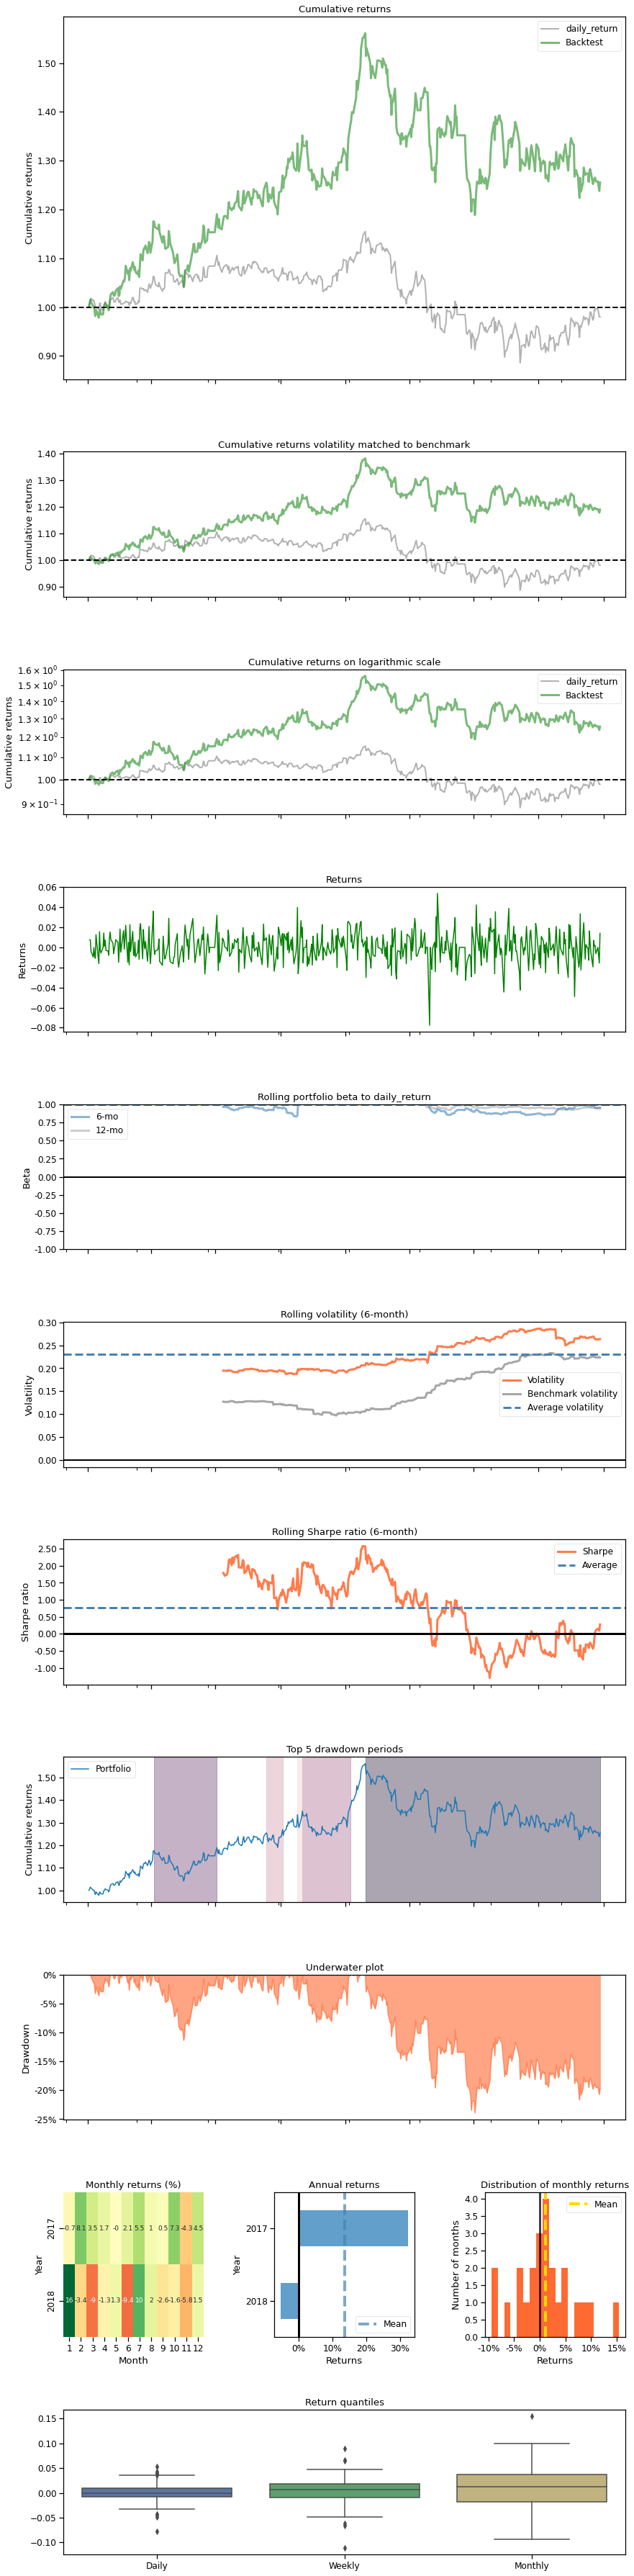

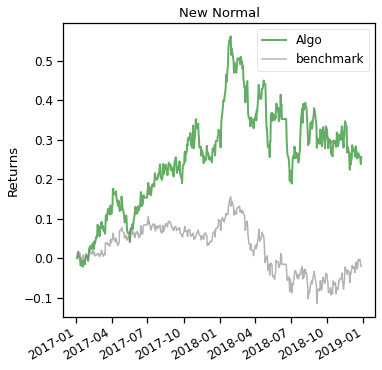

In [200]:
print("==============Compare to JKII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_a2c, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

==============Compare to JKII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (477, 8)


Start date,2017-01-03
End date,2018-12-27
Total months,23
,Backtest
Annual return,24.068%
Cumulative returns,52.747%
Annual volatility,19.527%
Sharpe ratio,1.20
Calmar ratio,1.43
Stability,0.86
Max drawdown,-16.824%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,16.82,2018-08-01,2018-11-12,NaT,NaN
1,12.04,2018-06-05,2018-07-03,2018-07-30,40
2,9.18,2018-02-23,2018-05-08,2018-05-29,68
3,5.75,2018-01-29,2018-02-09,2018-02-23,20
4,5.61,2017-11-07,2017-12-05,2018-01-02,41


Stress Events,mean,min,max
New Normal,0.09%,-4.81%,4.92%


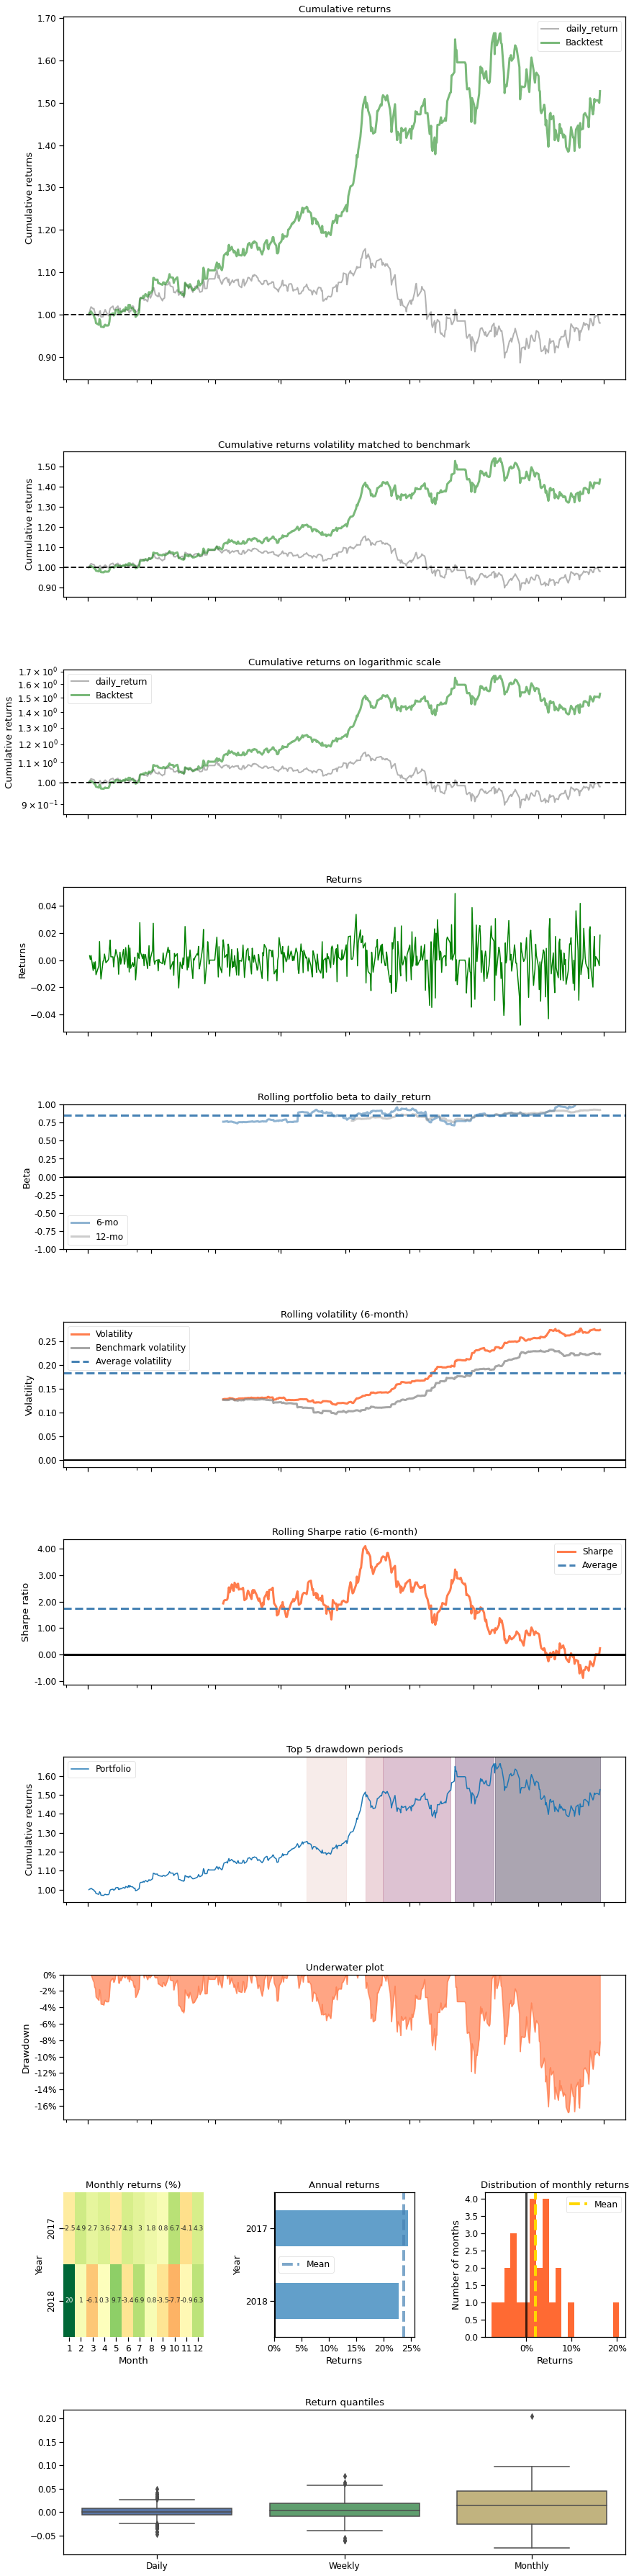

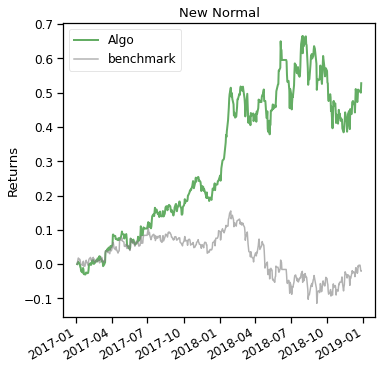

In [201]:
print("==============Compare to JKII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_ddpg, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

==============Compare to JKII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (477, 8)


Start date,2017-01-03
End date,2018-12-27
Total months,23
,Backtest
Annual return,12.912%
Cumulative returns,26.94%
Annual volatility,19.387%
Sharpe ratio,0.72
Calmar ratio,0.54
Stability,0.37
Max drawdown,-23.695%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.69,2018-01-29,2018-11-28,NaT,NaN
1,7.15,2017-04-06,2017-05-31,2017-07-20,76
2,3.65,2017-09-12,2017-09-28,2017-10-04,17
3,3.37,2018-01-02,2018-01-04,2018-01-16,11
4,2.83,2017-01-26,2017-01-31,2017-02-02,6


Stress Events,mean,min,max
New Normal,0.06%,-5.42%,4.25%


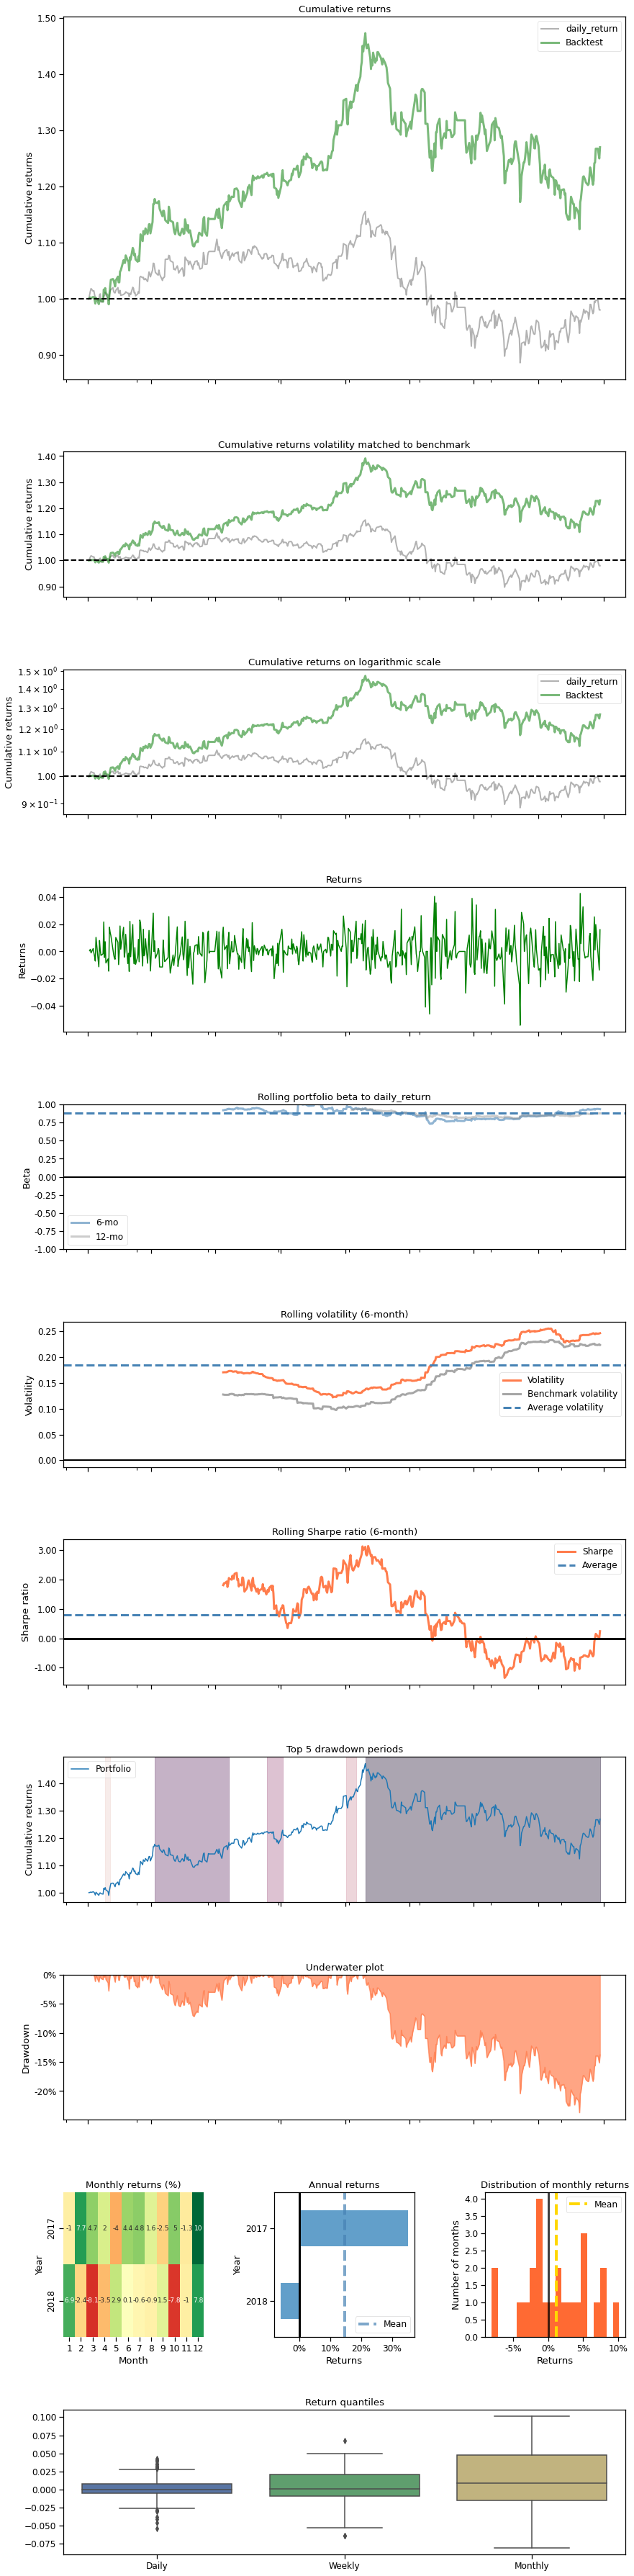

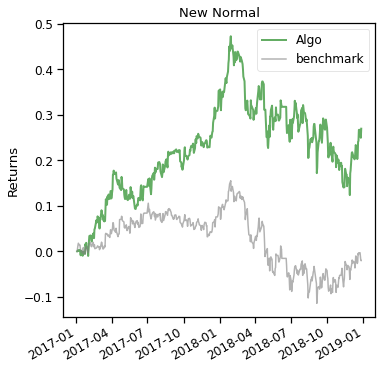

In [202]:
print("==============Compare to JKII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_ppo, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

==============Compare to JKII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (477, 8)


Start date,2017-01-03
End date,2018-12-27
Total months,23
,Backtest
Annual return,12.623%
Cumulative returns,26.302%
Annual volatility,18.195%
Sharpe ratio,0.75
Calmar ratio,0.82
Stability,0.63
Max drawdown,-15.404%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,15.40,2018-01-29,2018-06-28,NaT,NaN
1,6.54,2017-11-07,2017-12-06,2018-01-02,41
2,5.03,2017-04-26,2017-05-17,2017-06-14,36
3,3.68,2017-08-28,2017-09-27,2017-10-04,28
4,3.62,2017-07-03,2017-08-07,2017-08-24,39


Stress Events,mean,min,max
New Normal,0.05%,-5.11%,3.59%


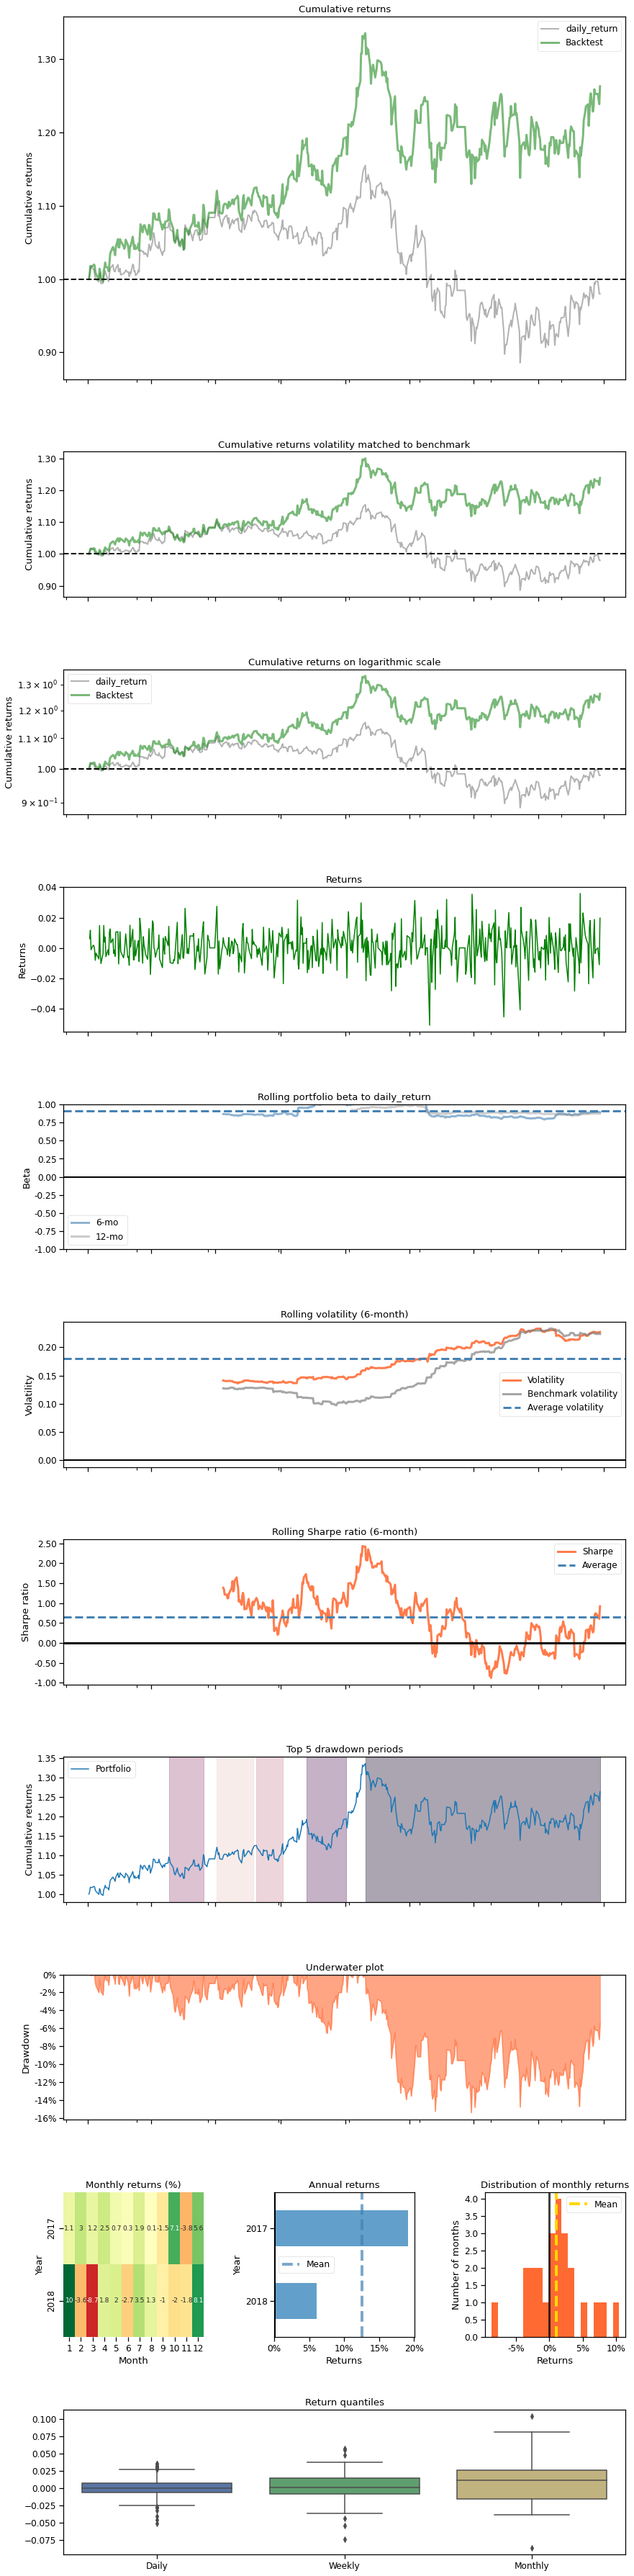

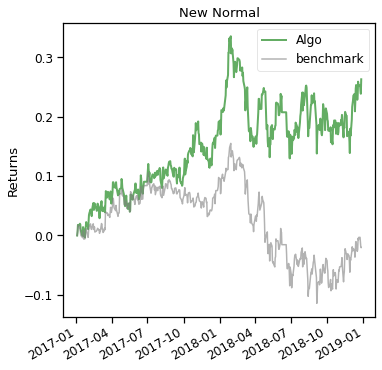

In [203]:
print("==============Compare to JKII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_td3, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

==============Compare to JKII===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (477, 8)


Start date,2017-01-03
End date,2018-12-27
Total months,23
,Backtest
Annual return,23.045%
Cumulative returns,50.283%
Annual volatility,24.709%
Sharpe ratio,0.96
Calmar ratio,1.01
Stability,0.80
Max drawdown,-22.707%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,22.71,2018-07-30,2018-11-30,NaT,NaN
1,14.60,2018-06-05,2018-06-28,2018-07-30,40
2,13.65,2017-04-05,2017-05-17,2017-07-13,72
3,11.61,2018-01-29,2018-03-20,2018-05-25,85
4,8.88,2017-11-01,2017-11-27,2018-01-08,49


Stress Events,mean,min,max
New Normal,0.09%,-6.80%,5.18%


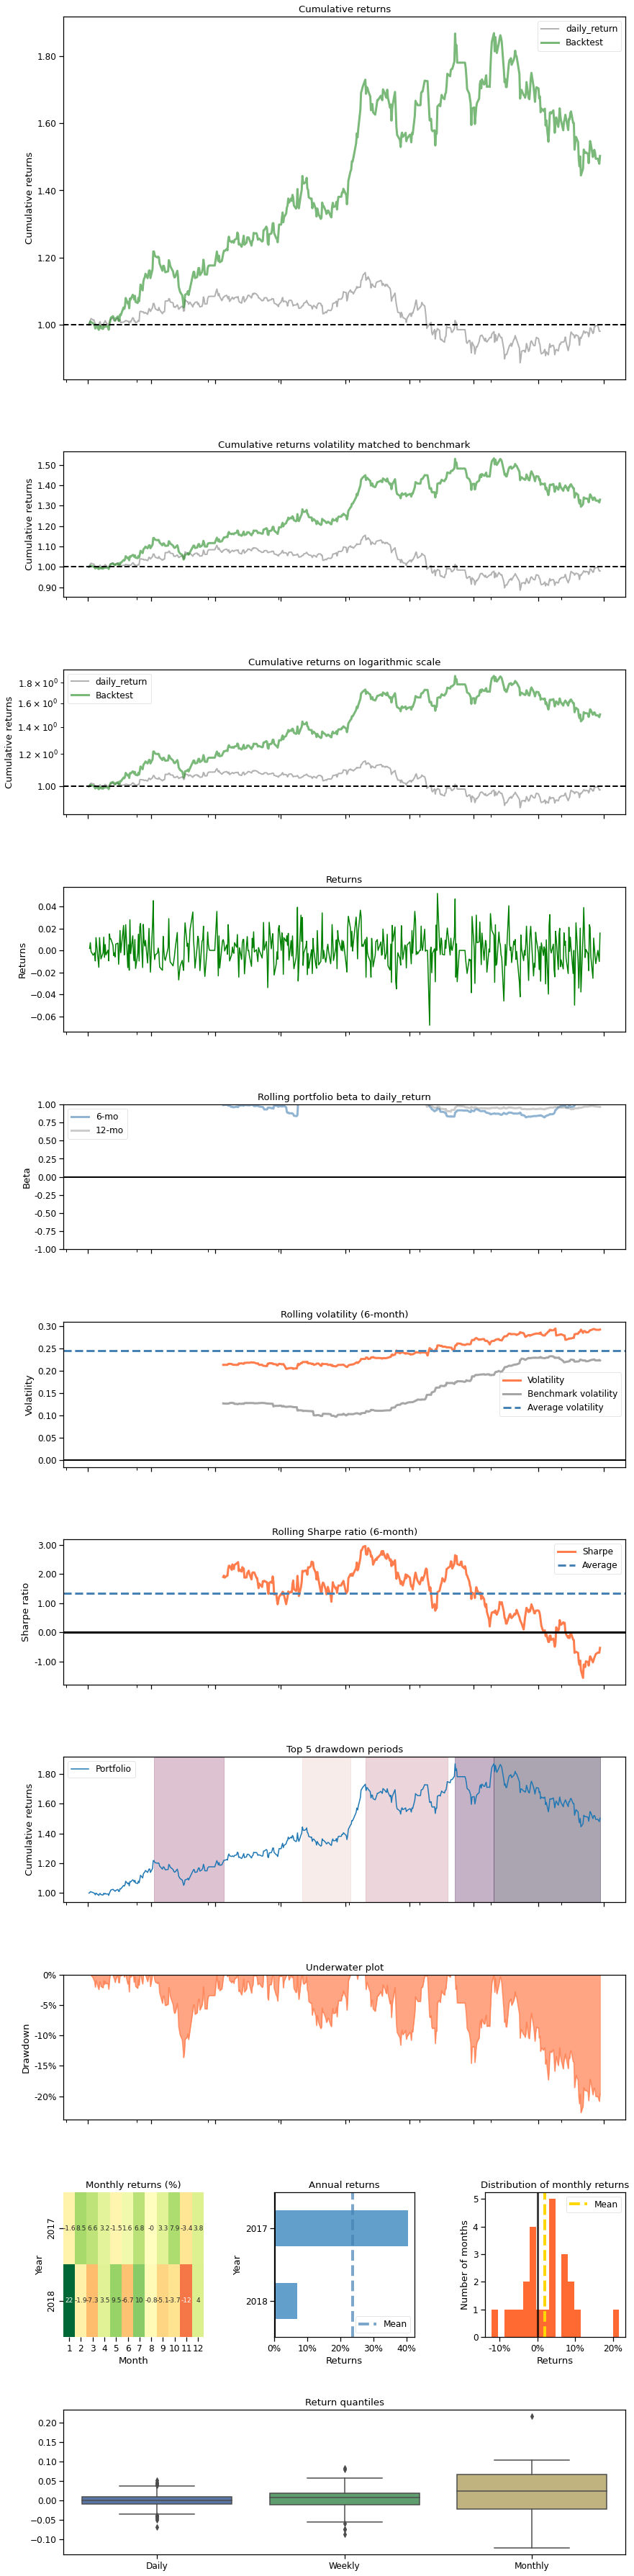

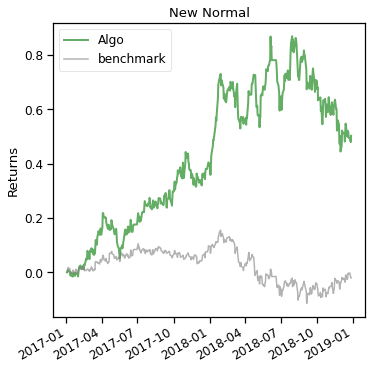

In [204]:
print("==============Compare to JKII===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_sac, 
             baseline_ticker = '^JKII', 
             baseline_start = df_account_value_a2c.loc[0,'date'],
             baseline_end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])